## Molecular dynamics of a small protein using GROMACS

First, you need to prepare your PDB file by removing any non-protein atoms (e.g., water, ligands)

# conda info --envs
# conda activate       /Users/bbroadway/miniconda3/envs/md-intro-tutorial



In [66]:
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
!pwd

/Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript


## Cleaning the input structure

Once you've had a look at the molecule, you are going to want to strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc). To delete those atoms (labelled "HETATM" in the PDB file) and eventually their connectivity, either use a plain text editor like vi, emacs (Linux/Mac), or Notepad (Windows). Do not use word processing software! Alternatively, you can use grep to delete these lines very easily:Once you've had a look at the molecule, you are going to want to strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc). To delete those atoms (labelled "HETATM" in the PDB file) and eventually their connectivity, either use a plain text editor like vi, emacs (Linux/Mac), or Notepad (Windows). Do not use word processing software! Alternatively, you can use grep to delete these lines very easily:

In [ ]:
!grep -v 'CONECT\|MISSING' TNKS_SAM.pdb > TNKS_SAM_tmp.pdb
#!grep -v HETATM TNKS_SAM_tmp.pdb > TNKS_SAM_tmp.pdb
#Only use the above if you dont have a phospho and want to remove HETATMs

## Generating a topology

Now we have verified that all the necessary atoms are present and the PDB file contains only protein atoms, and is ready to be input into GROMACS (see <a href=http://manual.gromacs.org/current/index.html> GROMACS documentation </a>). 
The first GROMACS tool, we use, is [`gmx pdb2gmx`](https://manual.gromacs.org/current/onlinehelp/gmx-pdb2gmx.html). The purpose of `gmx pdb2gmx` is to generate three files:

* The topology for the molecule.
* A position restraint file.
* A post-processed structure file. 

The topology (topol.top by default) contains all the information necessary to define the molecule within a simulation. This information includes nonbonded parameters (atom types and charges) as well as bonded parameters (bonds, angles, dihedrals and atom connectivity). We will take a more detailed look at the topology once it has been generated.

In [ ]:
!gmx pdb2gmx -f TNKS_SAM_tmp.pdb -o TNKS_SAM_processed.gro -water tip3p -ff charmm27


               :-) GROMACS - gmx pdb2gmx, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx pdb2gmx -f pT1053_tmp.pdb -o pT1053_processed.gro -water tip3p -ff charmm36

Using the Charmm36 force field in directory charmm36.ff

going to rename charmm36.ff/aminoacids.r2b
Opening force field file /Users/bbroadway/miniconda3/envs/md-intro-tutorial/share/gromacs/top/charmm36.ff/aminoacids.r2b

going to rename charmm36.ff/carb.r2b
Opening force field file /Users/bbroadway/miniconda3/envs/md-intro-tutorial/share/gromacs/top/charmm36.ff/carb.r2b

going to rename charmm36.ff/cgenff.r2b
Opening force field file /Users/bbroadway/miniconda3/envs/md-intro-tutorial/share/gromacs/top/charmm36.ff/cgenff.r2b

going to rename charmm36.ff/ethers.r2b
Opening force field

Here, we made an important decision for the course of the simulation in choosing the charmm27 all-atom force field. The force field will contain the information that will be written to the topology. This is a very important choice! You should always read thoroughly about each force field and decide which is most applicable to your situation. Other choices are given, when running `gmx pdb2gmx` without the -ff flag

# Solvating the simulation system

Now that you are familiar with the contents of the GROMACS topology, it is time to continue building our system. In this example, we are going to be simulating a simple aqueous system. It is possible to simulate proteins and other molecules in different solvents, provided that good parameters are available for all species involved.

There are two steps to defining the box and filling it with solvent:

- Define the box dimensions using the [`gmx editconf`](https://manual.gromacs.org/current/onlinehelp/gmx-editconf.html) tool.
- Fill the box with water using the [`gmx solvate`](https://manual.gromacs.org/current/onlinehelp/gmx-solvate.html) tool. 

You are now presented with a choice as to how to treat the unit cell. For the purpose of this tutorial, we will use the rhombic dodecahedron, as its volume is ~71% of the cubic box of the same periodic distance, thus saving on the number of water molecules that need to be added to solvate the protein.

## Defining the simulation box

Let's define the box using `gmx editconf`:

In [ ]:
!gmx editconf -f TNKS_SAM_processed.gro -o TNKS_SAM_newbox.gro -c -d 2.0 -bt cubic

               :-) GROMACS - gmx editconf, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx editconf -f pT1053_processed.gro -o pT1053_newbox.gro -c -d 2.0 -bt cubic

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2480 atoms
Volume: 103.312 nm^3, corresponds to roughly 46400 electrons
No velocities found
    system size :  5.994  4.601  3.746 (nm)
    diameter    :  6.573               (nm)
    center      :  0.014  0.106 -0.132 (nm)
    box vectors :  5.993  4.601  3.746 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 103.31               (nm^3)
    shift       :  5.272  5.180  5.418 (nm)
new center      :  5.286  5.286  5.286 (nm)
new box vectors : 10.573 10.573 10.573 (n

## Use editconf  to Recenter the Protein

In [ ]:
!gmx editconf -f TNKS_SAM_newbox.gro -o TNKS_SAM_centered.gro -c


               :-) GROMACS - gmx editconf, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx editconf -f pT1053_newbox.gro -o pT1053_centered.gro -c

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2480 atoms
Volume: 1181.85 nm^3, corresponds to roughly 531800 electrons
No velocities found
    system size :  5.994  4.601  3.746 (nm)
    center      :  5.286  5.286  5.286 (nm)
    box vectors : 10.573 10.573 10.573 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :1181.85               (nm^3)
    shift       :  0.000  0.000  0.000 (nm)
new center      :  5.286  5.286  5.286 (nm)

GROMACS reminds you: "In my opinion, we don't devote nearly enough scientific research to finding a c

## Check the Box Dimensions

In [ ]:
!gmx editconf -f TNKS_SAM_centered.gro -o checkbox.gro -c

               :-) GROMACS - gmx editconf, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx editconf -f pT1053_centered.gro -o checkbox.gro -c

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 2480 atoms
Volume: 1181.85 nm^3, corresponds to roughly 531800 electrons
No velocities found
    system size :  5.994  4.601  3.746 (nm)
    center      :  5.286  5.286  5.286 (nm)
    box vectors : 10.573 10.573 10.573 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :1181.85               (nm^3)
    shift       :  0.000  0.000  0.000 (nm)
new center      :  5.286  5.286  5.286 (nm)

GROMACS reminds you: "Give a Man a Fish" (Arrested Development)



## Filling the box with water

In [ ]:
!gmx solvate -cp TNKS_SAM_newbox.gro -cs spc216.gro -o TNKS_SAM_solv.gro -p topol.top

               :-) GROMACS - gmx solvate, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx solvate -cp pT1053_newbox.gro -cs spc216.gro -o pT1053_solv.gro -p topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van 

In [74]:
!tail topol.top


[ system ]
; Name
Protein in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_B     1
SOL             37838


# Adding Ions

We now have a solvated system that contains a charged protein. The output of `pdb2gmx` told us that the protein has a net charge of -2e (based on its amino acid composition). If you missed this information in the `pdb2gmx` output, look at the last line of each [ atoms ] directive in topology file; it should read  "qtot 1." for chain A and  "qtot -3." for chain L. Since life does not exist at a net charge, we must add ions to our system. Further, we aim to approximate physiological conditions and use therefore a NaCl concentration of 0.15 M.

## Preparing the input for "gmx genion"

The tool for adding ions within GROMACS is called [`gmx genion`](https://manual.gromacs.org/current/onlinehelp/gmx-genion.html). What `gmx genion` does is read through the topology and replace water molecules with the ions that the user specifies. The input is called a run input file, which has an extension of .tpr; this file is produced by the GROMACS grompp module (GROMACS pre-processor), which will also be used later when we run our first simulation. `grompp` processes the coordinate file and topology (which describes the molecules) to generate an atomic-level input (`.tpr`). The .tpr file contains all the parameters for all of the atoms in the system.

To produce a .tpr file with [`gmx grompp`](https://manual.gromacs.org/current/onlinehelp/gmx-grompp.html), we will need an additional input file, with the extension .mdp (molecular dynamics parameter file); `gmx grompp` will assemble the parameters specified in the .mdp file with the coordinates and topology information to generate a .tpr file.

An .mdp file is normally used to run energy minimization or an MD simulation, but in this case is simply used to generate an atomic description of the system. We can proceed with an completely empty .mdp file in this case, its only role is to create the .tpr file.

In [75]:
!touch ions.mdp

Assemble your .tpr file with the following:

In [ ]:
!gmx grompp -f ions.mdp -c TNKS_SAM_solv.gro -p topol.top -o ions.tpr

                :-) GROMACS - gmx grompp, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx grompp -f ions.mdp -c pT1053_solv.gro -p topol.top -o ions.tpr


NOTE 1 [file ions.mdp]:
  For a correct single-point energy evaluation with nsteps = 0, use
  continuation = yes to avoid constraining the input coordinates.

Setting the LD random seed to -1107296291

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file topol.top, line 48]:
  System has non-zero tot

Be aware that there are some `NOTE` in the output. In all other cases than generating an output `tpr` for `gmx genion` these are very important and may not be ignored, here however we only need the atomic-level description of our system in the binary file ions.tpr. We will pass this file to genion:

*Note: A lot of GROMACS tools promt for input at the command line. As this does not play well with the jupyter notebook setup, we feed the input to the command line with a print command and a newline \n substituting enter*

In [ ]:
!printf "SOL\n" | gmx genion -s ions.tpr -o TNKS_SAM_solv_ions.gro -conc 0.15 -p \
topol.top -pname NA -nname CL -neutral

                :-) GROMACS - gmx genion, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx genion -s ions.tpr -o pT1053_solv_ions.gro -conc 0.15 -p topol.top -pname NA -nname CL -neutral

Reading file ions.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file ions.tpr, VERSION 2024.3-conda_forge (single precision)
Will try to add 119 NA ions and 107 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 115994 elements
Group     1 (        Protein) has  2480 elements
Group     2 (      Protein-H) has  1244 elements
Group     3 (        C-alpha) has   158 elements
Group     4 (       Backbone) has   474 elements
Group     5 (      MainChain) has   630 elements
Group     6 (   MainChain+Cb) has   768 eleme

We chose group "SOL" for embedding ions. You do not want to replace parts of your protein with ions.

*Note: Make sure to run `gmx genion` only once. `gmx genion` edits the topology "in-place" and does not know if there are already Cl or Na ions in the system. If you run it over again, ions will be added until there is no water left to replace with ions.*

In the `gmx genion` command, we provide the structure/state file (-s) as input, generate a .gro file as output (-o), process the topology (-p) to reflect the removal of water molecules and addition of ions, define positive and negative ion names (-pname and -nname, respectively), and tell `gmx genion` to add ions necessary to neutralize the net charge on the protein by adding the correct number of negative ions (-neutral, which in this case will add 2 Na+ ions to offset the -2 charge on the protein). We further use genion to add a specified concentration of ions in addition to simply neutralizing the system by specifying the -neutral and -conc options in conjunction. Refer to the genion man page for information on how to use these options.

The names of the ions specified with -pname and -nname GROMACS are standardized and not dependent on the force-field. The specified ion names are always the elemental symbol in all capital letters, which is the [ moleculetype ] name that is then written to the topology. Residue or atom names may or may not append the sign of the charge (+/-), depending on the force field. Do not use atom or residue names in the genion command, or you will encounter errors in subsequent steps.

In [78]:
!tail -6 topol.top

; Compound        #mols
Protein_chain_A     1
Protein_chain_B     1
SOL         37612
NA               119
CL               107


If you see multiple lines of NA and CL, you most likely ran genion multiple times. Start over with the `pdb2gmx`.

# Energy minimisation

The solvated, electroneutral system is now assembled. Before we can begin dynamics, we must ensure that the system has no steric clashes or inappropriate geometry. The structure is relaxed through a process called energy minimization (EM).

To perform energy minimization, we are once again going to use `gmx grompp` to assemble the structure, topology, and simulation parameters into a binary input file (.tpr), then we will use GROMACS MD engine, mdrun, to run the energy minimization.

Assemble the binary input using `gmx grompp` using the .mdp parameter file, as input. The simulation parameter file (.mdp) determines how the simulation shall be run. Find more information on all the options in the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html) or in the following [webinar](https://bioexcel.eu/webinar-a-walk-through-simulation-parameter-options-mdp-files-for-gromacs-2019-12-05/). There are a lot of parameters that can be set, here we ony set the elemental parametes and leave everything else as default. Let's have a look at the input file:

In [ ]:
!gmx grompp -f data/input/emin-charmm.mdp -c TNKS_SAM_solv_ions.gro -p topol.top -o em.tpr -maxwarn 1

                :-) GROMACS - gmx grompp, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx grompp -f data/input/emin-charmm.mdp -c pT1053_solv_ions.gro -p topol.top -o em.tpr -maxwarn 1

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -168997381

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule ty

Make sure you have been updating your topol.top file when running genbox and genion, or else you will get lots of nasty error messages ("number of coordinates in coordinate file does not match topology," etc).

Once run, we will find the energy-minimized structure in a file called `em.gro`. Additionally to this we will find more information on the run in an ASCII-text log file of the EM process,  `em.log`, a file for storage of energy, `em.edr` and a binary full-precision trajectory `em.trr`. 


We are now ready to run mdrun to carry out the energy minimisation:

In [80]:
!gmx mdrun -v -deffnm em

                :-) GROMACS - gmx mdrun, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx mdrun -v -deffnm em

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file em.tpr, VERSION 2024.3-conda_forge (single precision)

Using 1 MPI thread
Using 8 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =           -1
Step=    0, Dmax= 1.0e-02 nm, Epot= -1.18286e+06 Fmax= 1.98552e+05, atom= 27930
Step=    1, Dmax= 1.0e-02 nm, Epot= -1.23074e+06 Fmax= 6.58720e+04, atom= 27930
Step=    2

The -v flag is for the impatient: it makes `gmx mdrun` verbose, such that it prints its progress to the screen at every step. Never use this flag if run in background, on a HPC center or on a local cluster, it prints unnecessary data in the standard output file. 
The -deffnm flag will define the file names of the input and output. So, if you did not name your grompp output "em.tpr," you will have to explicitly specify its name with the `gmx mdrun` -s flag.

In [81]:
!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg -xvg none

                :-) GROMACS - gmx energy, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx energy -f em.edr -o potential.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX      

## Determining if the run was successful

There are two very important factors to evaluate to determine if EM was successful. 

The first is the potential energy (printed at the end of the EM process, even without -v). Epot should be negative and (for a simple protein in water) on the order of 100000 kJ/mol, depending on the system size and number of water molecules

The second important feature is the maximum force, Fmax, the target for which was set in minim.mdp - "emtol = 1000.0" - indicating a target Fmax of no greater than 1000 kJ/(mol nm). It is possible to arrive at a reasonable Epot with Fmax > emtol. If this happens, your system may not be stable enough for simulation. Evaluate why it may be happening, and perhaps change your minimization parameters (integrator, emstep, etc).



## Analysing the run results

Let's do a bit of analysis. The em.edr file contains all of the energy terms that GROMACS collects during EM. You can analyze any .edr file using the GROMACS energy module.

To analyse or visualize simulation data in python or jupyter notebooks, we can output a simplified xvg format from gmx-analysis tools with the option `-xvg none`

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/3632922254.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy'])


<Figure size 640x480 with 0 Axes>

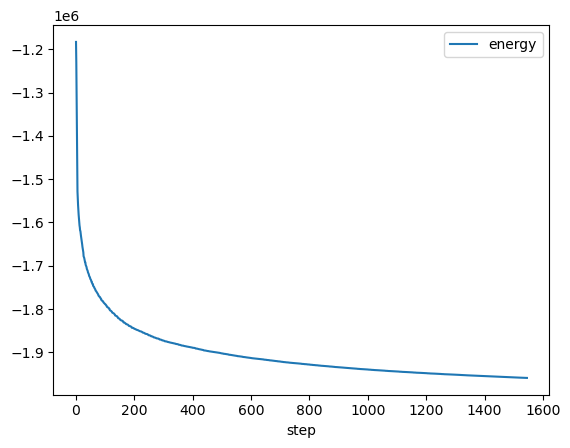

In [82]:
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy'])
plt.figure()
df.plot('step','energy')
plt.savefig('results/potential_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Now that our system is at an energy minimum, we can begin real dynamics.

# Position restraints 

EM ensured that we have a reasonable starting structure, in terms of geometry and solvent orientation. To begin real dynamics, we must equilibrate the solvent and ions around the protein. If we were to attempt unrestrained dynamics at this point, the system may collapse. The reason is that the solvent is mostly optimized within itself, and not necessarily with the solute, and ions are randomly placed by replacing water molecules.

Remember that posre.itp file that pdb2gmx generated a long time ago? We're going to use it now. The purpose of posre.itp is to apply a position restraining force on the heavy atoms of the protein (anything that is not a hydrogen). Movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to relax our solvent and ions around our protein, without the added variable of structural changes in the protein. The origin of the position restraints (the coordinates at which the restraint potential is zero) is provided via a coordinate file passed to the -r option of grompp. Depending from the protein and ion types, this process may also be in the order nanoseconds.

To use position restraints we need to add \"define = -DPOSRES\" to the simulation parameter file, .mdp, (more details on the simulation parameters below). Have a look at the .mdp file for this run:

In [83]:
!head -5 data/input/nvt-charmm.mdp 

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator


When using position restraints, a file with restraint coordinates must be supplied with -r to gmx grompp (see below). It can be the same file as supplied for -c. 

# Equilibration run - temperature

EM ensured that we have a reasonable starting structure, in terms of geometry and solvent orientation. Now the system needs to be brought to the temperature we wish to simulate and establish the proper orientation about the solute (the protein). After we arrive at the correct temperature (based on kinetic energies), we will apply pressure to the system until it reaches the proper density.

Equilibration is often conducted in two phases. The first phase is conducted under an NVT ensemble (constant Number of particles, Volume, and Temperature). This ensemble is also referred to as "isothermal-isochoric" or "canonical." The timeframe for such a procedure is dependent upon the contents of the system. Typically, 100-200 ps should suffice, and we will conduct a 100-ps NVT equilibration for this exercise. Depending on your machine, this may take a while (just under an hour if run in parallel on 16 cores or so).

We will call grompp and mdrun just as we did at the EM step, but this time with the energy minimised structure as input and a different .mdp file for the run. Have a look at the input file for this run:

In [84]:
!cat data/input/nvt-charmm.mdp

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

; Keep system temperature fluctuating physically correct
tcoupl                  = V-rescale           ; modified Berendsen thermostat
tc-grps                 = system   ; coupling groups 
tau_t                   = 1.0      ; time constant, in ps
ref_t                   = 300      ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl                  = no

; Velocity generation
gen_vel                 = yes                 ; assign velocities from Maxwell distribution
g

Instead of energy tolerance, we now give time a step size and a number of steps. Furthermore, we need to set a temperature. Now, we're good to run. Take note of a few parameters in the .mdp file:

- `gen_vel = yes`: Initiates velocity generation. Using different random seeds (gen_seed) gives different initial velocities, and thus multiple (different) simulations can be conducted from the same starting structure.
- `tcoupl = V-rescale`: The velocity rescaling thermostat is an improvement upon the Berendsen weak coupling method, which did not reproduce a correct kinetic ensemble.
- `pcoupl = no`: Pressure coupling is not applied. 

A full explanation of the parameters used can be found in the GROMACS [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html), in addition to the comments provided. 

In [85]:
!gmx grompp -f data/input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr 
!gmx mdrun -ntmpi 1 -v -deffnm nvt

                :-) GROMACS - gmx grompp, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx grompp -f data/input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to 1742717343

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'NA'

turnin

Let's analyze the temperature progression, again using gmx energy:

In [86]:
!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg -xvg none -b 20

                :-) GROMACS - gmx energy, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx energy -f nvt.edr -o temperature.xvg -xvg none -b 20

Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pr

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/3664536800.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('temperature.xvg', sep='\s+', header=None, names=['time','temperature'])


<Figure size 640x480 with 0 Axes>

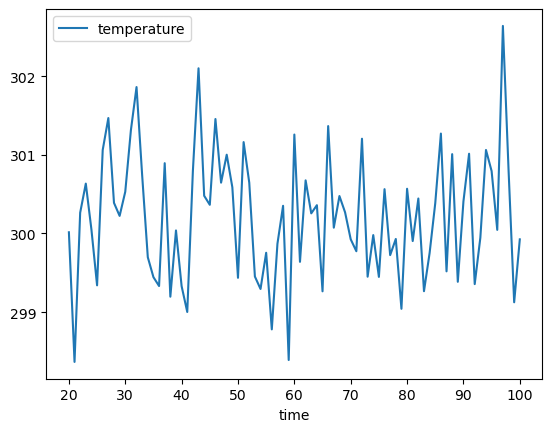

In [87]:
df = pd.read_csv('temperature.xvg', sep='\s+', header=None, names=['time','temperature'])
plt.figure()
df.plot('time', 'temperature')
plt.savefig('results/temperature_plot.png', dpi=300, bbox_inches='tight')
plt.show()

From the plot, it is clear that the temperature of the system quickly reaches the target value (300 K), and remains stable over the remainder of the equilibration. For this system, an equilibration period (on the order of 50 ps) may be adequate.

# Equilibration run - pressure

The previous step, NVT equilibration, stabilized the temperature of the system. Prior to data collection, we must also stabilize the pressure (and thus also the density) of the system. Equilibration of pressure is conducted under an NPT ensemble, wherein the Number of particles, Pressure, and Temperature are all constant. The ensemble is also called the "isothermal-isobaric" ensemble, and most closely resembles experimental conditions.

The .mdp file used for a 100-ps NPT equilibration can be found here. It is not drastically different from the parameter file used for NVT equilibration. Note the addition of the pressure coupling section. Berendsen barostat is used for this equilibation phase.

In [88]:
!cat data/input/npt-charmm.mdp

title                   = CHARMM NPT equilibration 
define                  = -DPOSRES  ; position restrain the protein 

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Pressure coupling is on
pcoupl                  = C-rescale             ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 5.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling        = com

; Keep sy

A few other changes:

- `continuation = yes`: We are continuing the simulation from the NVT equilibration phase
- `gen_vel = no`: Velocities are read from the trajectory (see below) 

We will call grompp and mdrun just as we did for NVT equilibration. Note that we are now including the -t flag to include the checkpoint file from the NVT equilibration; this file contains all the necessary state variables to continue our simulation. To conserve the velocities produced during NVT, we must include the final coordinate file (output) of the NVT simulation using the option (-c).

Now we'll start an MD simulation just like before - this one will take a few minutes; that's why it is commented out. Go ahead run it if you want to generate your own data.   

In [89]:
!gmx grompp -f data/input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

                :-) GROMACS - gmx grompp, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx grompp -f data/input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -335676065

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type

In [90]:
!gmx mdrun -ntmpi 1 -v -deffnm npt

                :-) GROMACS - gmx mdrun, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx mdrun -ntmpi 1 -v -deffnm npt

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file npt.tpr, VERSION 2024.3-conda_forge (single precision)
Changing nstlist from 10 to 80, rlist from 1.2 to 1.324


Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'Protein in water'
50000 steps,    100.0 ps.
step 49900, remaining wall clock time:     4 s          nish Thu Feb  6 18:55:12 2025, will finish Thu Feb  6 18:55:21 20257800, will fi

Let's analyze the pressure progression, again using energy:

In [91]:
!echo "Pressure" | gmx energy -f npt.edr -o pressure.xvg -xvg none

                :-) GROMACS - gmx energy, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx energy -f npt.edr -o pressure.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure   

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/84932906.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('pressure.xvg', sep='\s+', header=None, names=['time','pressure'])


<Figure size 640x480 with 0 Axes>

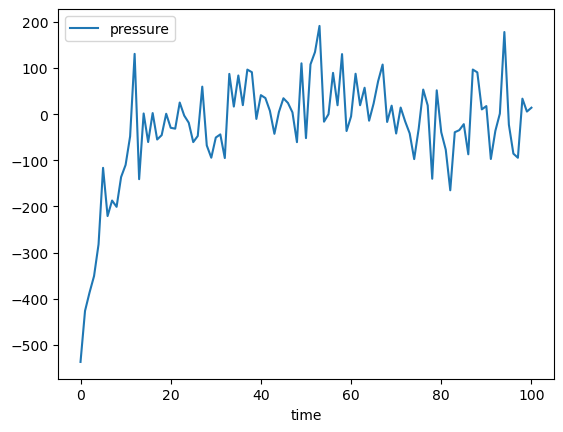

In [92]:
df = pd.read_csv('pressure.xvg', sep='\s+', header=None, names=['time','pressure'])
plt.figure()
df.plot('time', 'pressure')
plt.savefig('results/pressure_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [93]:
!echo "Density" | gmx energy -f npt.edr -o density.xvg -xvg none

                :-) GROMACS - gmx energy, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx energy -f npt.edr -o density.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure    

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/2423233739.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('density.xvg', sep='\s+', header=None, names=['time','density'])


<Figure size 640x480 with 0 Axes>

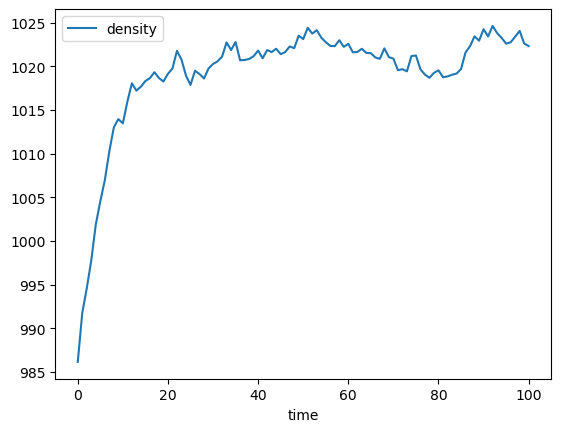

In [94]:
df = pd.read_csv('density.xvg', sep='\s+', header=None, names=['time','density'])
plt.figure()
df.plot('time', 'density')
plt.savefig('results/density_plot.png', dpi=300, bbox_inches='tight')
plt.show()

The average value is close to the experimental value of 1000 kg m-3 and the expected density of the TIP3P model of 1001 kg m-3. The parameters for the TIP3P water model closely replicate experimental values for water. The density values are very stable over time, indicating that the system is well-equilibrated now with respect to pressure and density.

Please note: Pressure-related terms are slow to converge, and thus you may have to run NPT equilibration slightly longer than is specified here.

# The "production" run

Upon completion of the two equilibration phases, the system is now well-equilibrated at the desired temperature and pressure. We are now ready to release the position restraints and run production MD for data collection. The process is just like we have seen before, as we will make use of the checkpoint file (which in this case now contains preserve pressure coupling information) to grompp. We will run a 1-ns MD simulation. Note we have explictly add a section that controls the output frequency in log file (.log), energy file (.edr), in the trajcotry file (.trr) and the compress trajectory file (.xtc).

In [95]:
!cat data/input/md-charmm.mdp

title                   = CHARMM NPT  

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 500000     ;  1000 ps = 1 ns

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Output control - output frequency in steps
; Output frequency for  output trajctory file ,trr
nstxout                  = 0       ; for writing coords (x) 
nstvout                  = 0       ; for writing velocities (v) 
nstfout                  = 0       ; for writing forces (f) 
; Output frequency for energies to log file and energy file
nstlog                   = 1000    ; for writing energies to log file
nstenergy                = 500     ; for writing energies to edr file 
; Output frequency and precision for .xtc file
nstxout-compressed       = 2500    ; for writing coords (x) 

; Pressure coupling is on
pcoupl     

Here, we use velocity-rescaling temperature coupling as thermostat and stochastic cell rescaling as barostat. A full explanation of the available thermostats and barostats in GROMACS can be found in the manual (see [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#temperature-coupling) for thermostat and [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#pressure-coupling) for barostat). 

Note, for thermostats and barostats we need to compute temperature or pressure. This requires global communication and is currently not done on GPU. To reduce these computational cost, [nsttcouple](https://manual.gromacs.org/current/user-guide/mdp-options.html#mdp-nsttcouple) and [nstpcouple](https://manual.gromacs.org/current/user-guide/mdp-options.html#mdp-nstpcouple) (frequency for coupling temperature/pressure) are set to 100 by default in GROMACS 2023 (see the webinar [What's new in GROMACS2023](https://www.gromacs.org/tutorial_webinar.html). The recommendation is to use tau_t = 1 ps for V-rescale and tau_p = 5 ps for C-rescale. 

`gmx grompp` will print an estimate for generated data and PME load. PME load will dictate how many processors should be dedicated to the PME calculation, and how many for the PP (everything except for PME) calculations. Refer to the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdrun-performance.html#parallelization-schemes) for details.

In [96]:
!gmx grompp -f data/input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

                :-) GROMACS - gmx grompp, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx grompp -f data/input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -1140867354

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_B'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'NA'

turni

In [97]:
!gmx mdrun -ntmpi 1 -v -deffnm md

                :-) GROMACS - gmx mdrun, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx mdrun -ntmpi 1 -v -deffnm md

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Changing nstlist from 10 to 80, rlist from 1.2 to 1.326


Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'Protein in water'
500000 steps,   1000.0 ps.
step 499900, remaining wall clock time:     4 s          ish Fri Feb  7 01:35:45 2025, will finish Fri Feb  7 01:35:58 2025, will finish 

# Analysis

Now that we have simulated our protein, we should run some analysis on the system. What types of data are important? This is an important question to ask before running the simulation, so you should have some ideas about the types of data you will want to collect in your own systems. For this tutorial, a few basic tools will be introduced.

The first tool is [`gmx trjconv`](https://manual.gromacs.org/current/onlinehelp/gmx-trjconv.html), which is used as a post-processing tool to strip out coordinates, correct for periodicity, or manually alter the trajectory (time units, frame frequency, etc). Here you find a suggested workflow for `gmx trjconv` [link](https://manual.gromacs.org/2021/user-guide/terminology.html?highlight=periodic%20boundary). This exercise, we will use `gmx trjconv` to account for any periodicity in the system. The protein will diffuse through the unit cell, and may appear "broken" or may "jump" across to the other side of the box. To account for such actions, issue the following:

In [98]:
!printf "1\n1\n" | gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol

               :-) GROMACS - gmx trjconv, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Select group for centering
Group     0 (         System) has 115542 elements
Group     1 (        Protein) has  2480 elements
Group     2 (      Protein-H) has  1244 elements
Group     3 (        C-alpha) has   158 elements
Group     4 (       Backbone) has   474 elements
Group     5 (      MainChain) has   630

Note, the protein should never interact with its periodic image (minimum image convention), otherwise the forces calculated will be spurious. To calculate the distance between the protein and its periodic image, we use the tool [`gmx mindist`](https://manual.gromacs.org/current/onlinehelp/gmx-mindist.html) with the option -pi. 

In [99]:
!printf "1\n" | gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg 

               :-) GROMACS - gmx mindist, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg

Choose a group for distance calculation
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Group     0 (         System) has 115542 elements
Group     1 (        Protein) has  2480 elements
Group     2 (      Protein-H) has  1244 elements
Group     3 (        C-alpha) has   158 elements
Group     4 (       Backbone) has   474 elements
Group     5 (      MainChain) has   630 elements
Group     6 (   MainChain+Cb) has   768 elements
Group     7 (    MainChain+H) has   792 elements
Group     8 (      SideChain) has  1688 elem

The distance between the protein and its periodic image should not be smaller than the cut-off used to describe non-bonded interactions.

Now let's look at structural stability. GROMACS has a built-in utility for RMSD calculations called [`gmx rms`](https://manual.gromacs.org/current/onlinehelp/gmx-rms.html). To calculate RMSD relative to the crystal structure, issue this command:

In [100]:
!printf "4\n1\n" | gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

                 :-) GROMACS - gmx rms, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

Reading file em.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file em.tpr, VERSION 2024.3-conda_forge (single precision)
Select group for least squares fit
Group     0 (         System) has 115542 elements
Group     1 (        Protein) has  2480 elements
Group     2 (      Protein-H) has  1244 elements
Group     3 (        C-alpha) has   158 elements
Group     4 (       Backbone) has   474 elements
Group     5 (      MainChain) has   630 elements
Group     6 (   MainChain+Cb) has   768 elements
Group     7 (    MainChain+H) has   792 elements
Group     8 (      SideChain) has  1688 e

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/1483893302.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('rmsd_xray.xvg', sep='\s+', header=None, names=['time','RMSD'])


<Figure size 640x480 with 0 Axes>

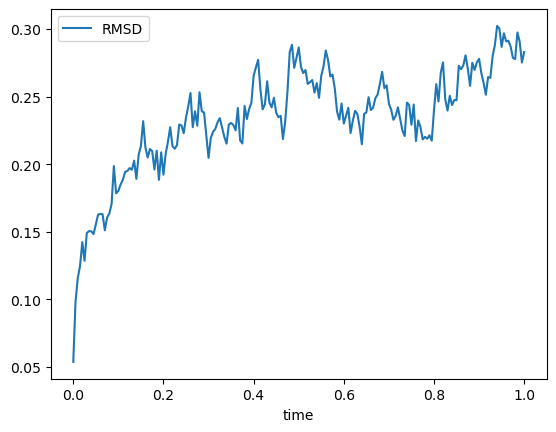

In [102]:
df = pd.read_csv('rmsd_xray.xvg', sep='\s+', header=None, names=['time','RMSD'])
plt.figure()
df.plot('time')
plt.savefig('results/rmsd_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
!gmx rms -h

                 :-) GROMACS - gmx rms, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/pT1053
Command line:
  gmx rms -h

SYNOPSIS

gmx rms [-s [<.tpr/.gro/...>]] [-f [<.xtc/.trr/...>]]
        [-f2 [<.xtc/.trr/...>]] [-n [<.ndx>]] [-o [<.xvg>]] [-mir [<.xvg>]]
        [-a [<.xvg>]] [-dist [<.xvg>]] [-m [<.xpm>]] [-bin [<.dat>]]
        [-bm [<.xpm>]] [-b <time>] [-e <time>] [-dt <time>] [-tu <enum>]
        [-[no]w] [-xvg <enum>] [-what <enum>] [-[no]pbc] [-fit <enum>]
        [-prev <int>] [-[no]split] [-skip <int>] [-skip2 <int>] [-max <real>]
        [-min <real>] [-bmax <real>] [-bmin <real>] [-[no]mw]
        [-nlevels <int>] [-ng <int>]

DESCRIPTION

gmx rms compares two structures by computing the root mean square deviation
(RMSD), the size-independent rho similarity pa

## Radius of gyration

The radius of gyration of a protein is a measure of its compactness. If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time. Let's analyze the radius of gyration for the protein in our simulation using GROMACS [`gmx gyrate`](https://manual.gromacs.org/current/onlinehelp/gmx-gyrate.html) tool:

In [103]:
!echo "1" | gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

                :-) GROMACS - gmx gyrate, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Last frame        200 time 1000.000   
Analyzed 201 frames, last time 1000.000

GROMACS reminds you: "I Feel a Great Disturbance in the Force" (The Emperor Strikes Back)



<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/3188974775.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('gyrate.xvg', sep='\s+', header=None, names=['time','Rg'], usecols=[0, 1])


<Figure size 640x480 with 0 Axes>

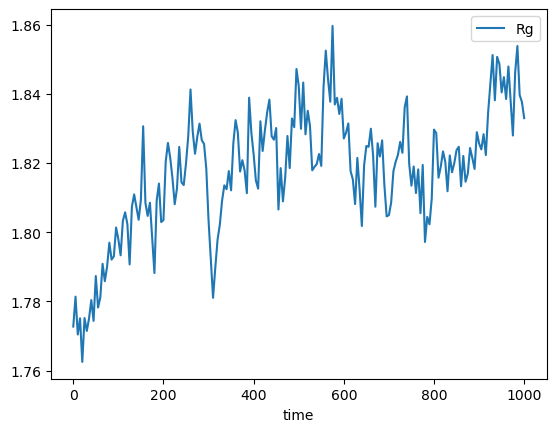

In [104]:
df = pd.read_csv('gyrate.xvg', sep='\s+', header=None, names=['time','Rg'], usecols=[0, 1])
plt.figure()
df.plot('time')
plt.savefig('results/gyrate_plot.png', dpi=300, bbox_inches='tight')
plt.show()


## Index file

Index groups are necessary for almost every GROMACS tools. All GROMACS tools can generate default index groups. If one needs special index groups, he/she can use gmx [gmx make_ndx](https://manual.gromacs.org/current/onlinehelp/gmx-make_ndx.html) to generate an index file (ndx). For example the command `splitch 1` splits the group 1 (Protein) in chains and the command `q`  close the tool.  

In [105]:
!printf "splitch 1\nq\n" | gmx make_ndx -f nvt.tpr -o 

               :-) GROMACS - gmx make_ndx, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx make_ndx -f nvt.tpr -o


Reading structure file
Reading file nvt.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file nvt.tpr, VERSION 2024.3-conda_forge (single precision)
Going to read 0 old index file(s)
Analysing residue names:
There are:   158    Protein residues
There are: 37612      Water residues
There are:   226        Ion residues
Analysing Protein...

  0 System              : 115542 atoms
  1 Protein             :  2480 atoms
  2 Protein-H           :  1244 atoms
  3 C-alpha             :   158 atoms
  4 Backbone            :   474 atoms
  5 MainChain           :   630 atoms
  6 MainChain+Cb        :   768 atoms
  7 MainChain+H        

Now we can calculate the hydrogen bonds between the two protein chains using the tool [gmx hbond](https://manual.gromacs.org/current/onlinehelp/gmx-hbond.html). The option -num provide the number of hydrogen bond as a function of time.  

In [106]:
!printf "17\n18\n"| gmx hbond -f md.xtc -s md.tpr  -n index.ndx -num -xvg none

                :-) GROMACS - gmx hbond, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx hbond -f md.xtc -s md.tpr -n index.ndx -num -xvg none

Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
Checking for overlap in atoms between Protein_chain1 (1240 atoms) and Protein_chain2 (1240 atoms)
Last frame        200 time 1000.000   
Analyzed 201 frames, last time 1000.000

GROMACS reminds you: "Don't Follow Me Home" (Throwing Muses)



<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/yv/5w2_0g5x19559474z_pgm559vcqh98/T/ipykernel_26897/2574822065.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('hbnum.xvg', sep='\s+', header=None, names=['time','H-bonds'], usecols=[0, 1])


<Figure size 640x480 with 0 Axes>

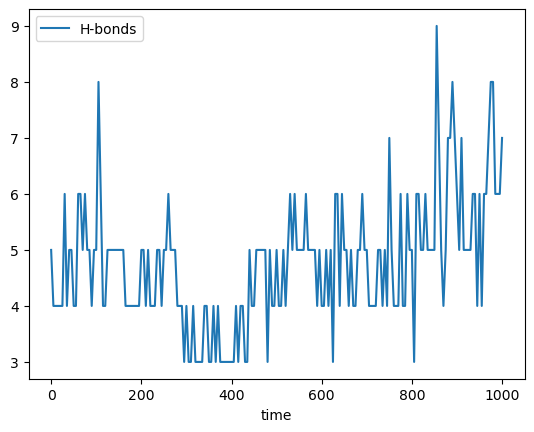

In [109]:
df = pd.read_csv('hbnum.xvg', sep='\s+', header=None, names=['time','H-bonds'], usecols=[0, 1])
plt.figure()
df.plot('time')
plt.savefig('results/hbnum_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## Report time

Now that we have runned the simulation, we should report or recall about what type of simulation we have per
formed. The GROMACS tool (`gmx report-methods`)[https://manual.gromacs.org/current/onlinehelp/gmx-report-methods.
html] can be useful for this purpose. gmx report-methods print out basic system information on a performed run. It can also provide an unformatted text (with the option -o) or a LaTeX formatted output file with the option -m. 
Let's try it.

In [110]:
!gmx report-methods -s md.tpr

            :-) GROMACS - gmx report-methods, 2024.3-conda_forge (-:

Executable:   /Users/bbroadway/miniconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/bbroadway/miniconda3/envs/md-intro-tutorial
Working dir:  /Users/bbroadway/Desktop/scripts/md-intro-tutorial/md-intro-tutorial-main/Finalscript
Command line:
  gmx report-methods -s md.tpr

Reading file md.tpr, VERSION 2024.3-conda_forge (single precision)
section: Methods
subsection: Simulation system
A system of 37840 molecules (115542 atoms) was simulated.

subsection: Simulation settings
A total of 1 ns were simulated with a time step of 2 fs.
Neighbor searching was performed every 10 steps.
The PME algorithm was used for electrostatic interactions.
with a cut-off of 1.2 nm.
A reciprocal grid of 72 x 72 x 72 cells was used with 4th order B-spline interpolation.
A single cut-off of 1.2 nm was used for Van der Waals interactions.
Temperature coupling was done with the V-rescale algorithm.
Pressure coupling was don